# Lineární modely pro klasifikaci

Podívejme se nyní na lineární modely pro klasifikaci. Takové modely se vyznačují tím, že se pokouší jednotlivé třídy od sebe oddělovat pomocí nadrovin v prostoru atributů. 

## Lineární regrese pro klasifikaci

Nejjednodušším způsobem (poté, co jsme si prošli předchozí část), jak vytvořit lineární model pro klasifikaci do $K$ tříd, je zakódovat cílové třídy pomocí vektorů $\{0,1\}^K$ tak, že 1 je na $i$-té pozici, když daná instance patří do třídy $i$. Pro každou třídu máme tedy vektor 0 a 1 délky $N$ a $p$ atributů. Není problém naučit se lineární model pro regresi, který se bude snažit předpovídat 0 a 1 a tedy příslušnost do dané třídy. Takových modelů natrénujeme stejně jako je tříd a při klasifikaci se všech zeptáme a jako předpovězenou třídu zvolíme tu, jejíž model vrátil největší hodnotu.

Ve skutečnosti není třeba počítat více lineárních regresí, stačí jednu s více výstupními hodnotami (multiple linear regression). Rozdíl je hlavně v tom, že výpočet je rychlejší, předpovědi pro jednotolivé třídy se níjak neovlivňují. Napíšeme-li si tedy cílové vektory do matice $Y$ po řádcích, odhady parametrů všech regresí dostaneme jako $$\hat{B} = (X^TX)^{-1}X^TY.$$ $B$ je tedy matice $(p \times K)$, její jednotlivé sloupečky odpovídají regresním koeficientům pro danou cílovou třídu. 

Hlavní nevýhodou tohoto přístupu je, že se může stát, že některá třída bude zcela zamaskována ostatními třídami, tj. při klasifikaci do ní nebudou přiřazeny žádné vzory. Podívejme se na to na následujícím příkladu.

Pocty instanci klasifikovanych do dane tridy: [154   0 146]


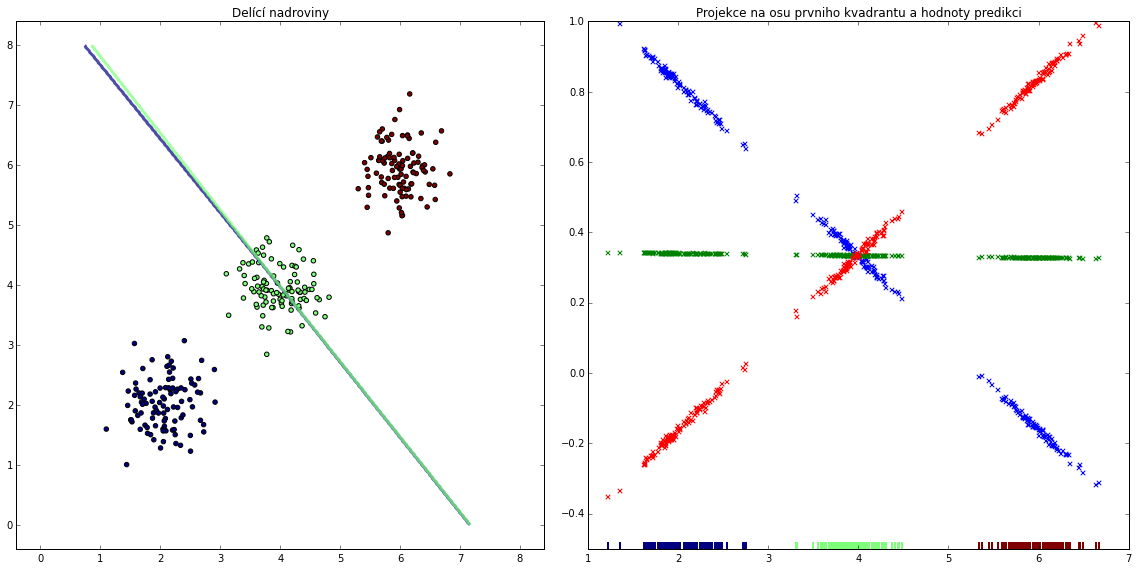

In [193]:
%matplotlib inline
from sklearn import linear_model
from sklearn import datasets
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# vygenerujeme si data
centers = [(2, 2), (4, 4), (6, 6)]
X, y = datasets.make_blobs(n_samples=300, n_features=2, cluster_std=0.4, centers=centers, shuffle=False, random_state=16)
X = np.hstack((np.ones(shape=(300, 1)), X))
Y = sm.categorical(y)[:, 1:] # zakodovani cilover tridy pomoci vektoru priznaku

# spocitame regresi jednou rucne
B = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)

# spocitame predikce a pocty instanci klasifikovanych do kazde tridy
pred = np.dot(X, B)
classes = np.argmax(pred, axis=1)
counts = np.bincount(classes)
print('Pocty instanci klasifikovanych do dane tridy:', counts)

# zakreslime delici nadroviny
XX, YY = np.meshgrid(np.linspace(0, 8, 500), np.linspace(0, 8, 500))
points = np.array([np.ones(500*500), XX.ravel(), YY.ravel()]).T
classes = np.argmax(np.dot(points, B), axis=1)
plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 2, 1)
ax.scatter(X[:, 1], X[:, 2], c=y)
ax.contour(XX, YY, classes.reshape(XX.shape), levels=[0,1,2], alpha=0.7, linewidths=[3])
ax.set_title('Delící nadroviny')
ax.set_aspect(1.0)

# na primce se smernici 1 jsou tridy snadno oddelitelne, spocitame projekci a zakreslime hodnoty predicki pro kazdou z nich
proj = (X[:, 1] + X[:, 2])/2
ax = plt.subplot(1,2,2)
ax.scatter(proj, np.zeros(300)-0.5, c=y, marker='|', s=200, linewidths=2)
ax.scatter(proj, pred[:, 0], c='blue', marker='x')
ax.scatter(proj, pred[:, 1], c='green', marker='x')
ax.scatter(proj, pred[:, 2], c='red', marker='x')
ax.set_ybound([-0.5, 1])
ax.set_xbound([1,7])
ax.set_title('Projekce na osu prvniho kvadrantu a hodnoty predikci')

plt.tight_layout()
plt.show()

## Lineárni diskriminační analýza (LDA)

cílem klasifikace je rozhodnout, do jaké třídy patří jaký vzorek. To se dá udělat například tak, že spočítáme pravděpodobnost, že daný vzorek patří do nějaké třídy a vybereme nejpravděpodobnější třídy. Předpokládejme, že máme funkci $f_k$, která nám dává pravděpodobnost výskytu vzorku $x$ za předpokladu, že patří do třídy $k$, a $\pi_k$ jsou apriorní pravděpodonosti příslušnosti do třídy $k$. Potom se dá prvaděpodobnost příslušnosti vzorku $x$ do třídy $k$ vyjádřit jako $$\mathrm{Pr}(G=k|X=x) = \frac{f_k(x)\pi_k}{\sum_{i=1}^Kf_i(x)\pi_i}.$$ 

Tento způsob funguje obecně, ať už funkce $f_k$ získáme jakkoliv. V případě LDA se volí funkce $$f_k(x) = \frac{1}{(2\pi)^{p/2}|\Sigma_k|^{1/2}}e^{-\frac{1}{2}(x-\mu_k)\Sigma_k^{-1}(x-\mu_k)}, $$ kde $\mu_k$ je střední hodnota vzorků z třídy $k$ a $\Sigma_k$ je konvarianční matice vzorků z třídy $k$. U LDA se navíc předpokládá, že kovarianční matice je pro všechny třídy stejná. Proč se ale takovému modelu říká _lineární_ diskriminační analýza? Podívejme se na hranici mezi dvěma třídama, k tomu se hodí spočítat si logaritmus poměru pravděpodobností těchto dvou tříd. Tam, kde je poměr pravděpodobností 1, tj. jeho logaritmus 0, máme potom hranici. $$\log\frac{\mathrm{Pr}(G=k|X=x)}{\mathrm{Pr}(G=l|X=x)} = \log\frac{f_k(x)}{f_l(x)} + \log\frac{\pi_k}{\pi_l} = \log\frac{\pi_k}{\pi_l}-\frac{1}{2}(\mu_k + \mu_l)\Sigma^{-1}(\mu_k-\mu_l)+x^T\Sigma^{-1}(\mu_k-\mu_l).$$ Vidíme, že tato hranice je lineární funkce $x$ a tedy třídy jsou odděleny pomocí nadrovin a to díky předpokladu na stejné kovarianční matice pro všechny třídy, ten zaručí, že se všechny vyšší členy při dělení vykrátí. Pokdu bychom tento předpoklad neměli, dostali bychom kvadratrickou diskriminační analýzu (QDA), hranice mezi třídami by byly kvadratické funkce. 

Otázkou zůstává, kde vzít hodnoty $\pi_k$, $\Sigma$ a $\mu_k$, to je ale jednoduché, dají se odhandout přímo z dat. 

- $\pi_k = N_k/N$
- $\mu_k = \sum_{g(x_i) = k}x_i/N_k$
- $\Sigma = \sum_{k=1}^K\sum_{g(x_i)=k}(x_i-\mu_k)(x_i-\mu_k)^T/(N-K)$

A to je vše, tím máme všechno, co potřebujeme pro LDA. Kdybychom navíc misto jedné matice $\Sigma$ používali všech $K$ matic $\Sigma_k$, dostali bychom QDA. Podívejme se, jak vypadají hranice určené podle lineární regrese, LDA a QDA na jednoduchých datech ve 2D. Jednou z výhod LDA je, že jí nehrozí maskování tříd, jako tomu bylo u předchozí metody.

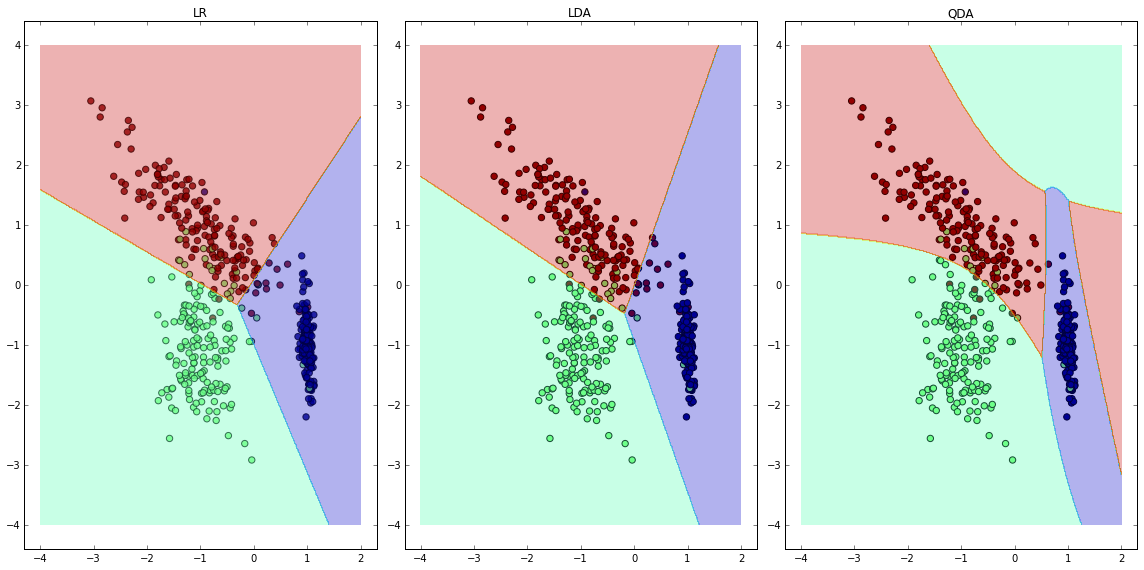

In [173]:
from sklearn import lda, qda

# vytovrime si jednoduchy dataset na klasifikaci
X, y = datasets.make_classification(n_samples=500, n_features=2, n_redundant=0, n_classes=3, n_clusters_per_class=1, 
                                    random_state=22)

XX, YY = np.meshgrid(np.linspace(-4, 2, 500), np.linspace(-4, 4, 500))
points = np.array([XX.ravel(), YY.ravel()]).T

#porovname delici nadroviny LDA, QDA, a LR
clf_lda = lda.LDA()
clf_lda.fit(X, y)
pred_lda = clf_lda.predict(points)

clf_qda = qda.QDA()
clf_qda.fit(X, y)
pred_qda = clf_qda.predict(points)

clf_lr = linear_model.LinearRegression()
clf_lr.fit(X, sm.categorical(y)[:, 1:])
pred_lr = np.argmax(clf_lr.predict(points), axis=1)

plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 3, 1)
ax.scatter(X[:, 0], X[:, 1], c=y, s=40, alpha=0.8)
ax.contourf(XX, YY, pred_lr.reshape(XX.shape), alpha=0.3)
ax.set_title('LR')

ax = plt.subplot(1, 3, 2)
ax.scatter(X[:, 0], X[:, 1], c=y, s=40)
ax.contourf(XX, YY, pred_lda.reshape(XX.shape), alpha=0.3)
ax.set_title('LDA')

ax = plt.subplot(1, 3, 3)
ax.scatter(X[:, 0], X[:, 1], c=y, s=40)
ax.contourf(XX, YY, pred_qda.reshape(XX.shape), alpha=0.3)
ax.set_title('QDA')

plt.tight_layout()
plt.show()

## Logistická regrese

Logistická regrese je navzdory svému jménu také klasifikační metoda. Má mnoho společného s LDA, ale její odvození a způsob odhadu parametrů je úplně jiný. U logistické regrese chceme, aby logaritmus poměrů pravděpodobností dvou tříd byl lineární funkce, tedy aby 
$$\eqalign{
   \log\frac{\mathrm{Pr}(G=1|X=x)}{\mathrm{Pr}(G=K|X=x)} &=\beta_{01}+\beta_1^Tx \cr
   \log\frac{\mathrm{Pr}(G=2|X=x)}{\mathrm{Pr}(G=K|X=x)} &=\beta_{02}+\beta_2^Tx \cr
   \vdots \cr
   \log\frac{\mathrm{Pr}(G=K-1|X=x)}{\mathrm{Pr}(G=K|X=x)} &=\beta_{0(K-1)}+\beta_{K-1}^Tx }$$ 

Jednoduchou úpravou z toho dostaneme vyjádření pravděpodobností jednotlivých tříd 
$$\eqalign{
    \mathrm{Pr}(G=k|X=x) &= \frac{e^{\beta_{0k} + \beta_k^Tx}}{1+\sum_{l=1}^{K-1}e^{\beta_{0l} + \beta_l^Tx}} \mathrm{~pro~} k = 1, \dots k-1  \cr
    \mathrm{Pr}(G=K|X=x) &= \frac{1}{1+\sum_{l=1}^{K-1}e^{\beta_{0l} + \beta_l^Tx}} \mathrm{~jinak}\cr
}$$

Nastavení parametrů modelu se hledá metodou maximální věrohodnosti, tj. maximaluzije se pomocí gradientní metody logaritmická věrohodonost $$l(\theta)=\sum_{i=1}^N\log\mathrm{Pr}(G=g(x_i)|X=x_i, \theta),$$ kde $g(x_i)$ je správná třída pro $x_i$.

Je zajímavé, že stejně jako u LDA i logistická regrese má hranice oddělující jednotlivé třídy specifikované jako přímky. Zdálo by se, že oba modely jsou stejné. Ve skutečnosti je logistická regrese o něco obecnější, protože nemá předpoklady na stejné kovariance jednotlivých tříd. V praxi ale obě metody dávají často podobné výsledky.

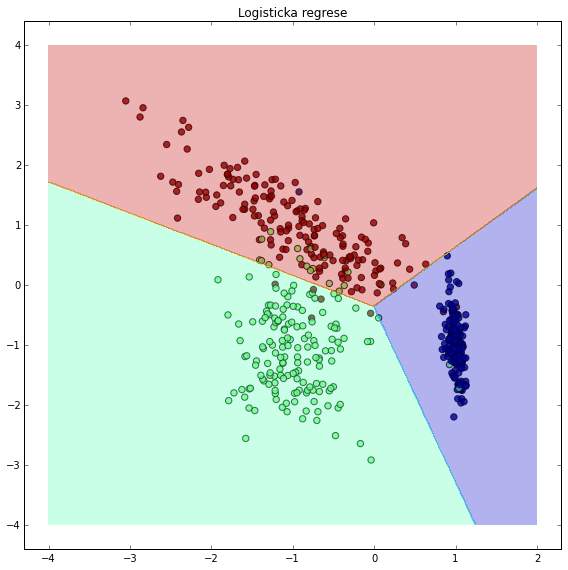

In [126]:
clf_logR = linear_model.LogisticRegression()
clf_logR.fit(X, y)
pred_logR = clf_logR.predict(points)

#zakreslime delici nadroviny pro logistickou regresi
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, alpha=0.8)
plt.contourf(XX, YY, pred_logR.reshape(XX.shape), alpha=0.3)
plt.title('Logisticka regrese')
plt.tight_layout()
plt.show()

## Perceptron

Poslední dva modely, na které se podíváme modelují dělící nadrovinu přímo. Hledá se tedy vektor $\beta$, takový, že dělící nadrovina je dána předpisem $x^T\beta + \beta_0 = 0$. Cílové třídy se v tomto případě kódují jako 1 a -1 a perceptron minimalizuje $$D(\beta, \beta_0) = - \sum_{i \in M}y_i(x_i^T\beta + \beta_0),$$ kde $M$ je množina vzorů, které jsou špatně klasifikované. Perceptron tuto hodnotu minimalizuje pomocí gradientního algoritmu, derivací podle $\beta$ a $\beta_0$ dostaneme pravidlo pro jeden krok $\beta_0 \leftarrow \rho y_i, \beta \leftarrow \rho y_ix_i$ (derivace be skutečnosti obsahuju sumu přes množinu $M$, perceptron tedy dělá tzv. stochastic gradient descend, protože mění odhad po předložení každého vzoru a ne dávkově). Dá se dokázat, že pro lineárně separabilní množiny perceptronový algoritmus vždy najde dělící nadrovinu. 

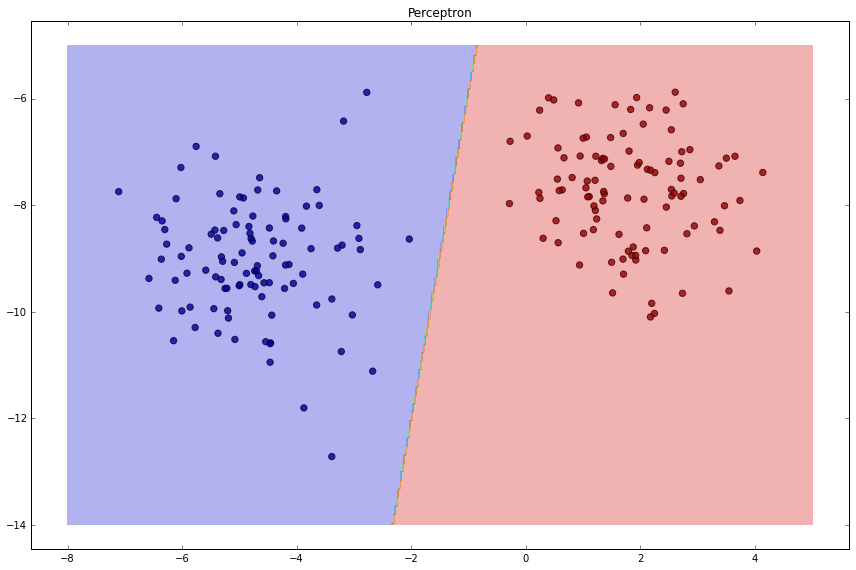

In [195]:
#vytvorime linearne separabilni mnoziny (zalezi na seedu)

X, y = datasets.make_blobs(n_features=2, n_samples=200, centers=2, random_state=68)

# zakreslime delici nadrovinu pro perceptron
XX, YY = np.meshgrid(np.linspace(-8, 5, 500), np.linspace(-14, -5, 500))
points = np.array([XX.ravel(), YY.ravel()]).T

clf_perc = linear_model.Perceptron()
clf_perc.fit(X, y)
pred_perc = clf_perc.predict(points)

plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, alpha=0.8)
plt.contourf(XX, YY, pred_perc.reshape(XX.shape), alpha=0.3)
plt.title('Perceptron')
plt.tight_layout()
plt.show()

## Maximum margin separating hyperplane

Nadrovina nalezená pomocí perceptronu není určena jednoznačně, algoritmus může najít libovolnou z nadrovin, které data oddělují, konkrétní nalezená nadrovina záleží na počáteční inicializaci algoritmu. Tento problém řeší maximum margin separating hyperplane (MMSH). Ten navíc hledá takovou nadrovinu, která je co nejdále od obou množin. Snaží se tedy řešit problém $$\max_{\beta, \beta_0, ||\beta||=1} M$$  za podmínek $$y_i(x_i^T\beta+\beta_0) \geq M$$ pro každé $i$. To se dá ekvivalentně zapsat jako $$\min_{\beta, \beta_0}\frac{1}{2}||\beta||^2$$ za podmínek $$y_i(x_i^T\beta+\beta_0) \geq 1.$$ Tento problém se následně řeší pomocí metod kvadratického programování.

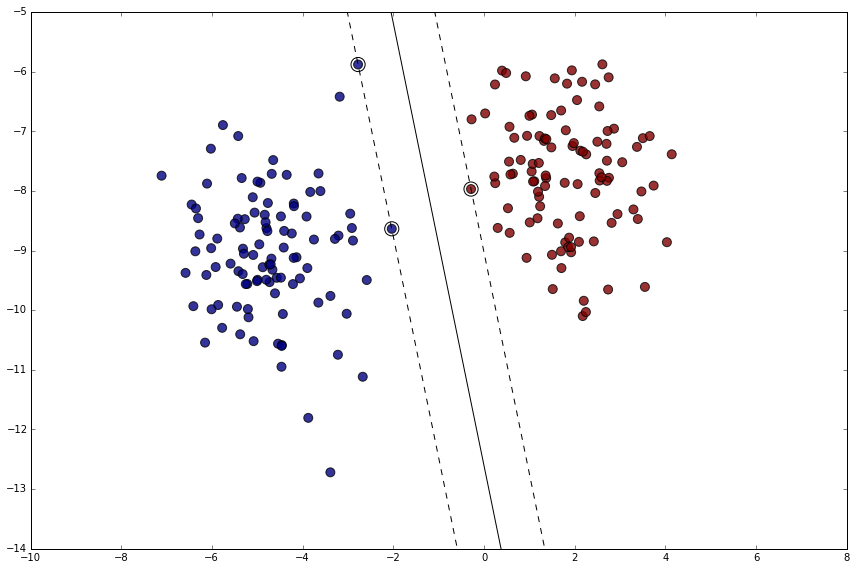

In [196]:
from sklearn import svm

# najdeme maximalni separujici nadrovinu
clf_mmc = svm.SVC(kernel='linear')
clf_mmc.fit(X, y)

# zakreslime do grafu margin, support vectory a delici nadrovinu (ukradeno z dokumentace sklearn)
w = clf_mmc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-8, 6)
yy = a * xx - (clf_mmc.intercept_[0]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors
b = clf_mmc.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = clf_mmc.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

# plot the line, the points, and the nearest vectors to the plane
plt.figure(figsize=(12,8))
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf_mmc.support_vectors_[:, 0], clf_mmc.support_vectors_[:, 1], s=200, facecolors='none')
plt.scatter(X[:, 0], X[:, 1], c=y, s=80, alpha=0.8)
plt.gca().set_ybound([-14,-5])

plt.tight_layout()
plt.show()